<a href="https://colab.research.google.com/github/AhmedEhab2022/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine learning
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Google Colab integration
from google.colab import drive

Import and mount the dataset

In [ ]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Customer Segmentation/Mall_Customers.csv'

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic info

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.shape

(200, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Cleaning the dataset

## Check for duplicates and missing values

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


## Get relevant features

In [ ]:
df_relevant = df[['Annual Income (k$)', 'Spending Score (1-100)']]
df_relevant.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


## Scale relevant features

Scaling is required for K-Means and DBSCAN because both algorithms rely on distance metrics to measure similarity between points. Without scaling, features with larger ranges dominate the distance calculation, leading to biased clustering results.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_relevant)

df_scaled = pd.DataFrame(X_scaled, columns=["Scaled Annual Income", "Scaled Spending Score"])
df_scaled.head()

,Scaled Annual Income,Scaled Spending Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


# Exploratory Data Analysis

## Annual Income vs Spending Score (Before Clustering)

### Raw data

Text(0.5, 1.0, 'Annual Income vs Spending Score (Before Clustering)')

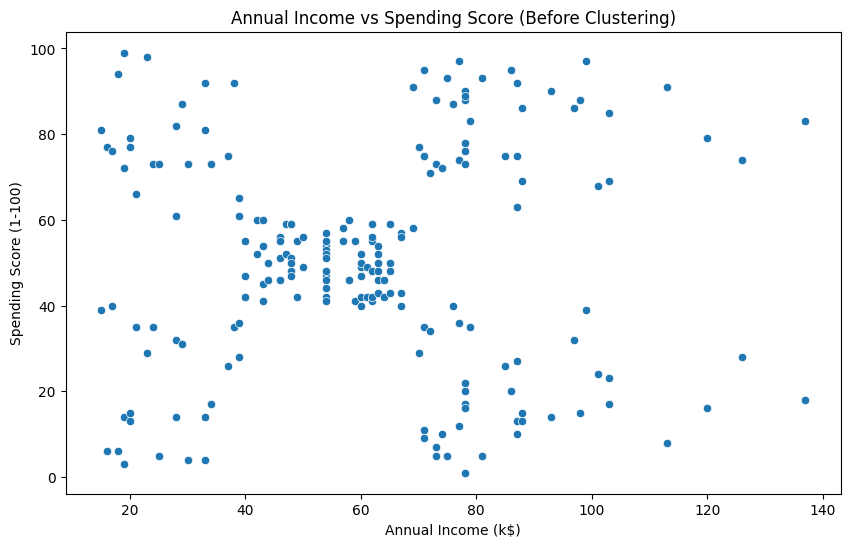

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_relevant, x='Annual Income (k$)', y='Spending Score (1-100)')
plt.title('Annual Income vs Spending Score (Before Clustering)')

### Scaled data

Text(0.5, 1.0, 'Annual Income vs Spending Score (Before Clustering)')

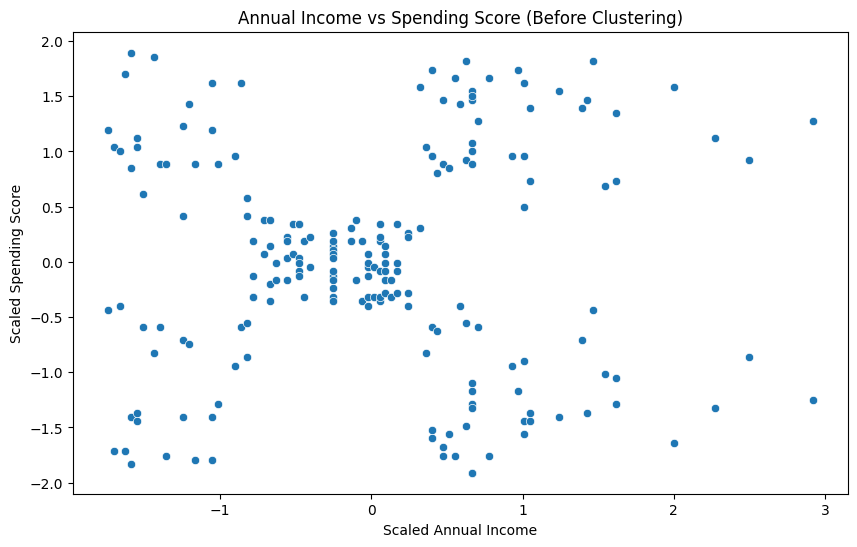

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled, x='Scaled Annual Income', y='Scaled Spending Score')
plt.title('Annual Income vs Spending Score (Before Clustering)')

## Features distributions (Before Clustering)

### Raw data

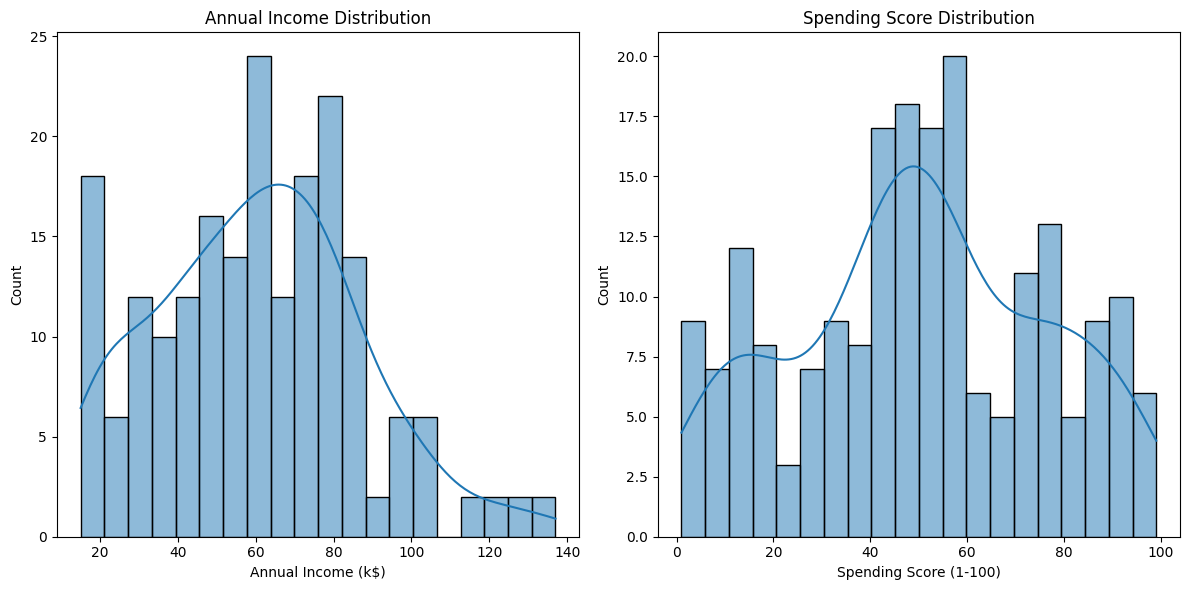

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True)
plt.title('Annual Income Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

#### Age distribution

Text(0.5, 1.0, 'Age Distribution')

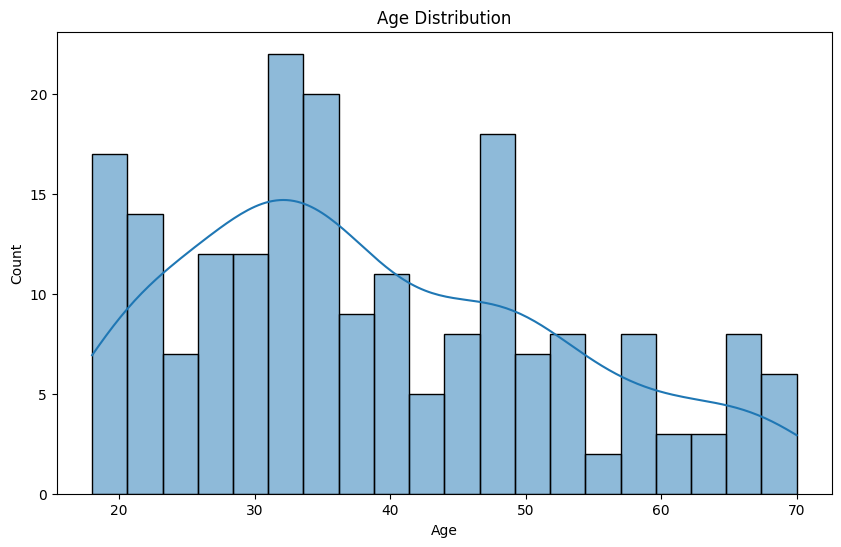

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')

### Scaled data

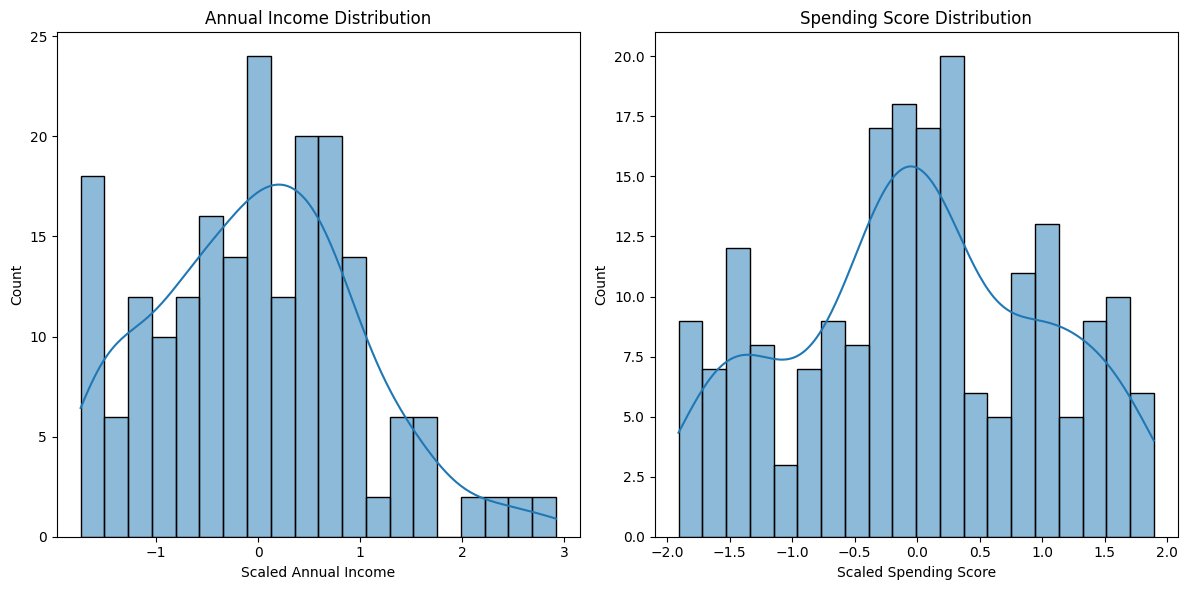

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_scaled['Scaled Annual Income'], bins=20, kde=True)
plt.title('Annual Income Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df_scaled['Scaled Spending Score'], bins=20, kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

## Check outliers

### Raw data

In [ ]:
px.box(df, x='Annual Income (k$)', title='Annual Income Boxplot')

In [ ]:
px.box(df, x='Spending Score (1-100)', title='Spending Score Boxplot')

In [ ]:
px.box(df, x='Age', title='Age Boxplot')

### Scaled data

In [ ]:
px.box(df_scaled, x='Scaled Annual Income', title='Annual Income Boxplot')

In [ ]:
px.box(df_scaled, x='Scaled Spending Score', title='Spending Score Boxplot')

No outliers in Spending Score and Age and one outlier in Annual Income.

The K-Means algorithm is sensitive to outliers, as outliers can distort the centroids (the center of each cluster), unlike Density-Based Spatial Clustering of Applications with Noise (DBSCAN).

# Clustering

## K-Means

K-Means algorithm requires a predefined number of clusters (k).

Initially, I will choose k to equal 5 as the Annual Income vs Spending Score scatter plot shows approximately 5 clusters.

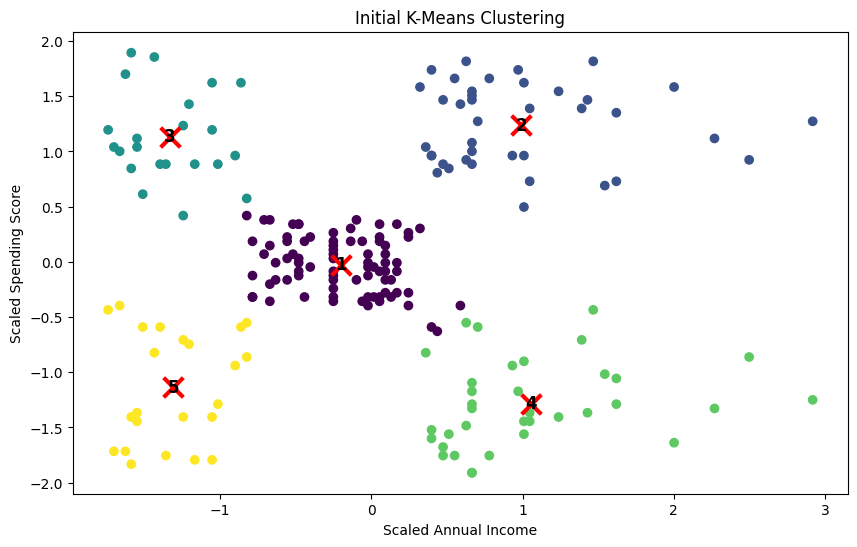

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

def plot_k_means_clusters(df, title, labels, cluster_centers):
  plt.figure(figsize=(10, 6))
  plt.scatter(df['Scaled Annual Income'], df['Scaled Spending Score'], c=labels, cmap='viridis')
  # Plot centroids
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=200, linewidths=3, color='r')
  # Add the cluster number to the plot
  for i, (x, y) in enumerate(cluster_centers):
    plt.text(x, y, str(i + 1), fontsize=12, weight='bold', horizontalalignment='center', verticalalignment='center', color="black")
  plt.title(title)
  plt.xlabel('Scaled Annual Income')
  plt.ylabel('Scaled Spending Score')
  plt.show()

plot_k_means_clusters(df_scaled, "Initial K-Means Clustering",  kmeans_labels, kmeans.cluster_centers_)

## Hierarchical clustering

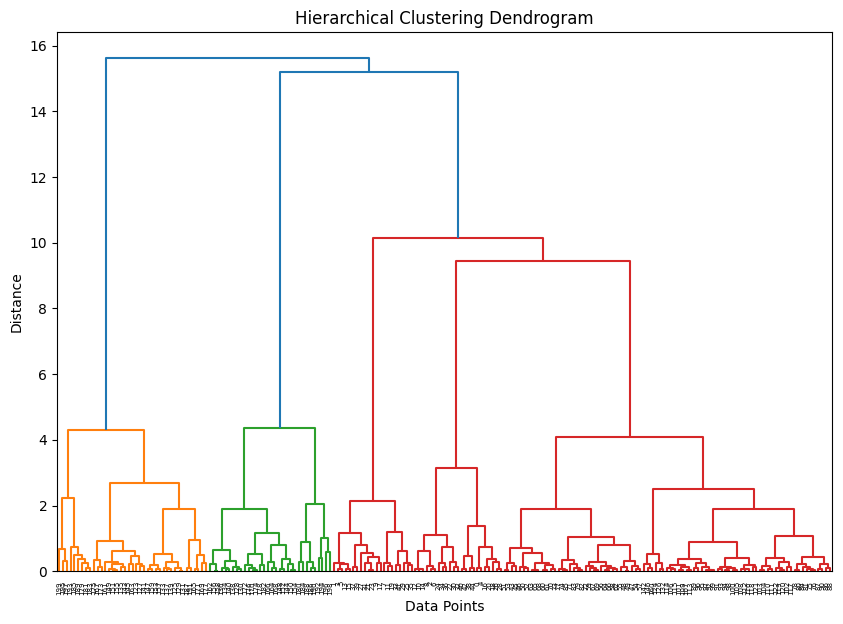

In [ ]:
# ward method merges clusters that lead to the smallest increase in total within-cluster variance.
linked = linkage(df_scaled, 'ward')

# plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

## DBSCAN

Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

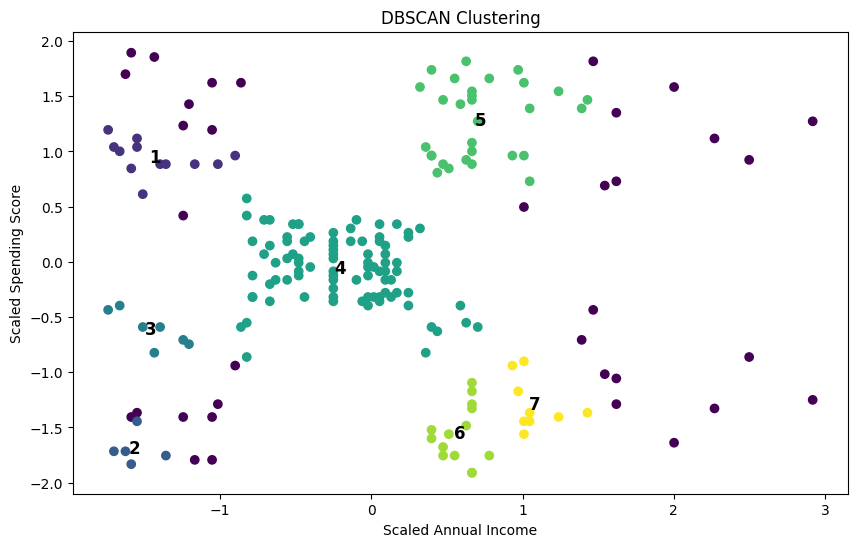

In [ ]:
# eps (epsilon / radius): defines the maximum distance between two points for them to be considered neighbors.
# min_samples: the minimum number of points required to form a dense region (a cluster).
# eps=0.5 and min_samples=5 are the default values
# eps=0.3 to decrease the radius
dbscan = DBSCAN(eps=0.3)
dbscan_labels = dbscan.fit_predict(df_scaled)


def plot_DBSCAN_clusters(df, title, labels):
  plt.figure(figsize=(10, 6))
  plt.scatter(df['Scaled Annual Income'], df['Scaled Spending Score'], c=labels, cmap='viridis')
  unique_labels = set(labels)
  for label in unique_labels:
      if label == -1:
          continue
      # Get the points for the current cluster
      cluster_points = df[labels == label]
      # Compute cluster center (mean of points)
      x_mean, y_mean = cluster_points.mean(axis=0)
      plt.text(x_mean, y_mean, str(label + 1), fontsize=12, weight='bold',
              horizontalalignment='center', verticalalignment='center', color="black")
  plt.title(title)
  plt.xlabel('Scaled Annual Income')
  plt.ylabel('Scaled Spending Score')
  plt.show()

plot_DBSCAN_clusters(df_scaled, "DBSCAN Clustering", dbscan_labels)

The dark purple points are detected as noise.

# Determine optimal number of clusters

The silhouette score is a metric for evaluating the quality of clustering in unsupervised machine learning, measuring how well a data point fits its own cluster compared to other clusters. It ranges from -1 to +1, with scores near +1 indicating compact, well-separated clusters, a score near 0 suggesting overlapping clusters, and a score near -1 pointing to points potentially assigned to the wrong cluster. The overall score is the average of individual point scores, reflecting the balance between a point's intra-cluster cohesion and its inter-cluster separation.

In [ ]:
def get_optimal_number_of_clusters(data):
  best_k = None
  best_score = -1
  for k in range(2, 11):
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans_labels = kmeans.fit_predict(df_scaled)
      silhouette_avg = silhouette_score(df_scaled, kmeans_labels, random_state=42)
      if silhouette_avg > best_score:
          best_score = silhouette_avg
          best_k = k
      print(f"k = {k}: Silhouette Score = {silhouette_avg}")
  return best_k, best_score


best_k, best_score = get_optimal_number_of_clusters(df_scaled)
print(f"\nOptimal number of clusters: {best_k}")
print(f"Best Silhouette Score: {best_score}")

k = 2: Silhouette Score = 0.3973270007887498
k = 3: Silhouette Score = 0.46658474419000145
k = 4: Silhouette Score = 0.49434988482196784
k = 5: Silhouette Score = 0.5546571631111091
k = 6: Silhouette Score = 0.5138257534676561
k = 7: Silhouette Score = 0.50200146805547
k = 8: Silhouette Score = 0.4550112502601921
k = 9: Silhouette Score = 0.4566624374485964
k = 10: Silhouette Score = 0.44475993501732874

Optimal number of clusters: 5
Best Silhouette Score: 0.5546571631111091


# Perform K-Means with the optimal number of clusters

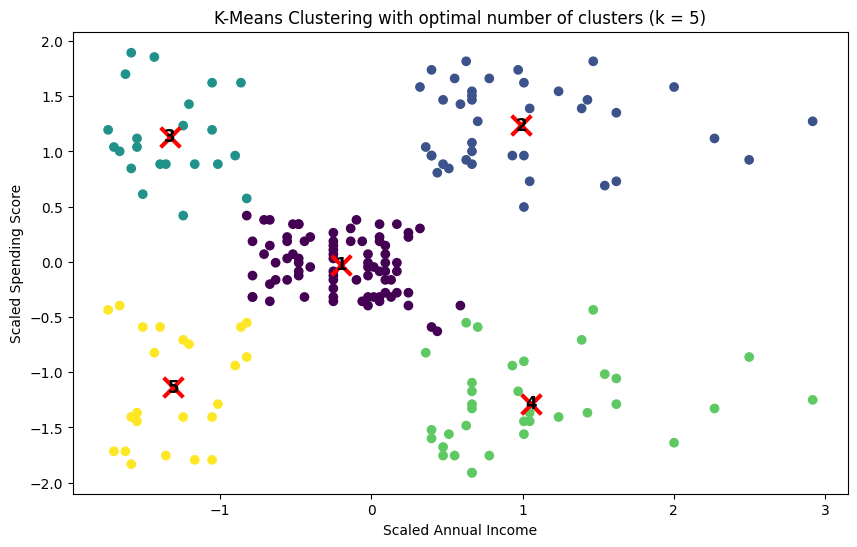

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

plot_k_means_clusters(df_scaled, f"K-Means Clustering with optimal number of clusters (k = {best_k})", kmeans_labels, kmeans.cluster_centers_)

# Perform K-Means with the optimal number of clusters after removing outliers

In [ ]:
df_scaled_no_outliers = df_scaled[df_scaled['Scaled Annual Income'] < 2.5]

px.box(df_scaled_no_outliers, x='Scaled Annual Income', title='Annual Income Boxplot')

In [ ]:
best_k_no_outliers, best_score_no_outliers = get_optimal_number_of_clusters(df_scaled_no_outliers)
print(f"\nOptimal number of clusters: {best_k_no_outliers}")
print(f"Best Silhouette Score: {best_score_no_outliers}")

k = 2: Silhouette Score = 0.3973270007887498
k = 3: Silhouette Score = 0.46658474419000145
k = 4: Silhouette Score = 0.49434988482196784
k = 5: Silhouette Score = 0.5546571631111091
k = 6: Silhouette Score = 0.5138257534676561
k = 7: Silhouette Score = 0.50200146805547
k = 8: Silhouette Score = 0.4550112502601921
k = 9: Silhouette Score = 0.4566624374485964
k = 10: Silhouette Score = 0.44475993501732874

Optimal number of clusters: 5
Best Silhouette Score: 0.5546571631111091


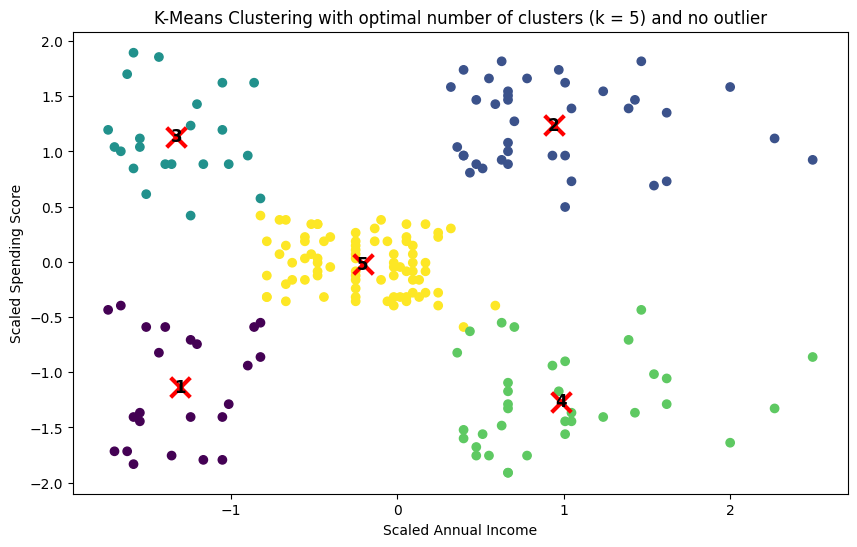

In [ ]:
kmeans_no_outlier = KMeans(n_clusters=best_k_no_outliers, random_state=42)
kmeans_labels_no_outlier = kmeans_no_outlier.fit_predict(df_scaled_no_outliers)

title = f"K-Means Clustering with optimal number of clusters (k = {best_k_no_outliers}) and no outlier"
plot_k_means_clusters(df_scaled_no_outliers, title, kmeans_labels_no_outlier, kmeans_no_outlier.cluster_centers_)

The same number of clusters and the same centroids are obtained with and without the outlier. However, the first and fifth clusters are swapped.

This happens because the K-Means algorithm does not assign any inherent meaning to cluster labels; the order of centroids may vary between runs, even if the clusters themselves remain the same.

# Clusters analysis

In [ ]:
def mode(x):
  return x.mode()[0] if not x.mode().empty else None


def get_cluster_summary(df, labels):
  # to make it one based
  df['Cluster'] = labels + 1

  cluster_summary = df.groupby('Cluster').agg(
      {'Cluster': 'size', 'Gender': mode, 'Age': 'mean', 'Annual Income (k$)': 'mean', 'Spending Score (1-100)': 'mean'}
  ).rename(columns={
      'Gender': 'Mode Gender',
      'Age': 'Average Age', 'Annual Income (k$)': 'Average Annual Income (k$)',
      'Spending Score (1-100)': 'Average Spending Score (1-100)', 'Cluster': 'Number of Customers'
  })
  cluster_summary.sort_values(by='Average Spending Score (1-100)', ascending=False, inplace=True)
  return cluster_summary


get_cluster_summary(df, kmeans_labels)

,Number of Customers,Mode Gender,Average Age,Average Annual Income (k$),Average Spending Score (1-100)
Cluster,,,,,
2,39,Female,32.692308,86.538462,82.128205
3,22,Female,25.272727,25.727273,79.363636
1,81,Female,42.716049,55.296296,49.518519
5,23,Female,45.217391,26.304348,20.913043
4,35,Male,41.114286,88.200000,17.114286


The max average spending is in cluster 2.

Cluster 2:

Young customers with high annual income and very high spending scores. They represent the most valuable group for luxury and premium offerings.

Cluster 3:

Very young customers with relatively low income but surprisingly high spending scores. This group may be driven by trends or lifestyle aspirations, making them an opportunity for affordable luxury or fast-fashion products.

Cluster 1:

Middle-aged customers with moderate income and average spending scores. They represent a stable, mainstream group that balances saving and spending.


Cluster 5:

Older customers with low income and low spending scores. They are cautious with spending, often prioritizing essential or value-for-money purchases.

Cluster 4:

Middle-aged customers with high income but very low spending scores. This group has strong purchasing power but tends to save more, possibly preferring investments over consumption.